# 📈 Aylık Satış Tahmini: XGBoost ve Prophet Karşılaştırmalı Zaman Serisi Analizi

---

## 📌 Problem Tanımı

Bu çalışmada **2015–2018** yılları arasındaki satış verileri kullanılarak  
**aylık satış tahmini (time series forecasting)** problemi ele alınmıştır.

Zaman serisi problemlerinde model seçimi, veri yapısına ve örüntülerin doğasına bağlı olarak önemli ölçüde değişmektedir.  
Bu nedenle farklı yaklaşım türlerine sahip iki model karşılaştırılmıştır.

---

## 🎯 Çalışmanın Amaçları

Bu analiz kapsamında hedeflenenler:

- Küçük ölçekli veri setlerinde farklı model yaklaşımlarının performansını karşılaştırmak  
- Feature-based makine öğrenmesi modeli (**XGBoost**) ile  
  additive zaman serisi modeli (**Prophet**) arasındaki farkları analiz etmek  
- Model seçiminin veri yapısına bağlı olarak nasıl değiştiğini göstermek  
- Performans metrikleri üzerinden bilimsel ve objektif değerlendirme yapmak  

---

## 🧠 Model Yaklaşımları

### 1️⃣ XGBoost (Feature-Based Machine Learning)

- Lag feature'lar
- Rolling mean özellikleri
- Takvimsel değişkenler (ay, yıl, vb.)
- Gözetimli öğrenme yaklaşımı

Bu model, zaman serisini bir regresyon problemine dönüştürerek tahmin üretir.

---

### 2️⃣ Prophet (Additive Time Series Model)

- Trend bileşeni
- Mevsimsellik (seasonality)
- Tatil/özel gün etkileri (varsa)
- Otomatik bileşen ayrıştırma

Bu model, zaman serisini bileşenlerine ayırarak açıklanabilir tahmin üretir.

---

## 🔍 Neden Bu Karşılaştırma?

Zaman serisi analizinde:

- Veri küçükse
- Mevsimsellik belirginsa
- Trend yapısı karmaşıksa

Farklı model türleri farklı performans gösterebilir.

Bu çalışma yalnızca tahmin üretmeyi değil,  
**model seçiminin bilimsel temellerini ortaya koymayı** amaçlamaktadır.

---

## 📊 Değerlendirme Kriterleri

Modeller aşağıdaki metrikler üzerinden karşılaştırılmıştır:

- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)
- Görsel tahmin performansı
- Overfitting analizi

---

> Bu notebook, model karşılaştırmasını metodolojik ve sistematik bir yaklaşımla ele almaktadır.


# 1️⃣ Problem Tanımı

---

## 🏢 İş Dünyasında Satış Tahmininin Önemi

Satış tahmini, işletmeler için yalnızca analitik bir problem değil,  
aynı zamanda stratejik bir karar destek mekanizmasıdır.

Doğru tahminler aşağıdaki alanlarda kritik rol oynar:

- 📦 **Stok planlaması**  
- 🎯 **Kampanya ve pazarlama stratejileri**  
- 💰 **Nakit akışı yönetimi**  
- ⚙️ **Operasyonel planlama**

Yanlış tahminler; fazla stok maliyeti, stok yetersizliği, gelir kaybı ve operasyonel aksaklıklara neden olabilir.

---

## 🎯 Çalışmanın Hedefi

Bu çalışmada temel amaç:

> **Gelecek ayın toplam satış miktarını tahmin etmek**

Problem, aylık toplam satış üzerinden tek değişkenli bir zaman serisi tahmin problemine dönüştürülmüştür.

---

## 📊 Veri Yapısı

Orijinal veri:

- İşlem bazlı (transaction-level) satış kayıtları

Dönüştürme adımı:

- Aylık toplam satışa göre agregasyon
- 2015–2018 dönemini kapsayan **48 aylık zaman serisi**

---

## 🔎 Veri Özellikleri

- Belirgin yıllık sezonluk yapı
- Düşük örnek sayısı (small data scenario)
- Trend ve mevsimsellik içeren yapı

Bu özellikler, model seçimini doğrudan etkileyen temel faktörlerdir.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from prophet import Prophet

C:\Users\Mehmet Ersolak\.conda\envs\veriBilimi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2️⃣ Veri Hazırlama

---

## 📂 Ham Veri Yapısı

Veri seti işlem (transaction) bazlıdır.  
Her satır tek bir satış işlemini temsil etmektedir.

Bu yapı doğrudan zaman serisi modeline uygun değildir.

---

## 🔄 Dönüştürme Süreci

Zaman serisi modeli kurabilmek için:

- Satışlar tarih bazında gruplanmıştır  
- Aylık toplam satış miktarı hesaplanmıştır  
- Veri aylık frekansa dönüştürülmüştür  

Sonuç olarak:

> 48 gözlemden oluşan aylık zaman serisi elde edilmiştir.

---

## 🎯 Bu Adım Neden Kritik?

Modelin hedef değişkeni:

> **Aylık toplam satış miktarıdır**

Dolayısıyla modelin öğreneceği yapı:

- Trend bileşeni  
- Yıllık mevsimsellik  
- Zaman içindeki değişim dinamikleri  

İşlem bazlı veri ile aylık tahmin üretmek metodolojik olarak tutarsız olurdu.  
Bu nedenle doğru agregasyon, model başarısının temelidir.

In [3]:
df = pd.read_csv("C:/Users/Mehmet Ersolak/Documents/GitHub/sales_forecasting_project/data/raw/train.csv")

df["Order Date"] = pd.to_datetime(df["Order Date"], dayfirst=True)
df = df.sort_values("Order Date")

monthly = (
    df
    .set_index("Order Date")
    .resample("ME")["Sales"]
    .sum()
    .reset_index()
)

monthly.columns = ["Date", "Sales"]
monthly.head()

,Date,Sales
0,2015-01-31,14205.707
1,2015-02-28,4519.892
2,2015-03-31,55205.797
3,2015-04-30,27906.855
4,2015-05-31,23644.303


# 3️⃣ Keşifsel Veri Analizi (EDA)

---

## 📈 Trend Analizi

Zaman serisi görselleştirildiğinde aylık satışlarda genel olarak  
**artan bir trend yapısı** gözlemlenmektedir.

Bu durum:

- İşletmenin büyüme eğiliminde olduğunu  
- Talebin zaman içinde arttığını  
- Uzun vadeli pozitif momentum bulunduğunu  

göstermektedir.

---

## 📊 Sezonluk Gözlemler

Özellikle **4. çeyrek (Ekim–Kasım–Aralık)** dönemlerinde  
belirgin satış artışları dikkat çekmektedir.

Bu durum aşağıdaki faktörlerden kaynaklanabilir:

- Yıl sonu kampanyaları  
- Özel günler ve tatil sezonu  
- Tüketici harcama davranışındaki dönemsel artış  

Bu yapı, seride güçlü bir **yıllık mevsimsellik (annual seasonality)** bulunduğunu göstermektedir.

---

## 🔎 Modelleme Açısından Önemi

Trend ve sezonluk yapı:

- Prophet gibi additive modeller için doğal bir kullanım alanı sunar  
- XGBoost gibi ML modellerinde ise lag ve takvimsel feature'larla yakalanmalıdır  

Bu nedenle EDA çıktıları, model tasarım stratejisini doğrudan belirlemektedir.

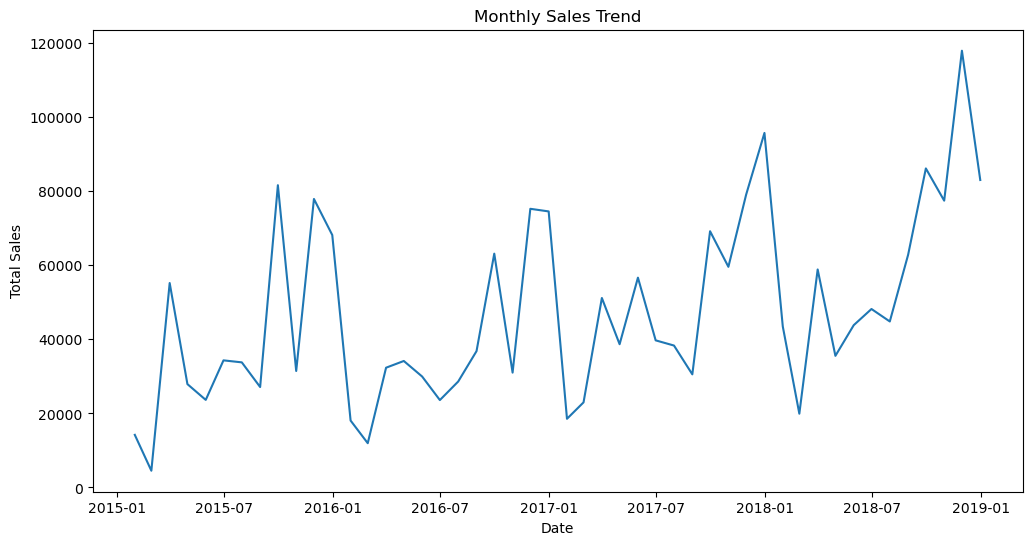

In [4]:
plt.figure(figsize=(12,6))
plt.plot(monthly["Date"], monthly["Sales"])
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

## 🔄 Seasonality Analizi

Aylara göre ortalama satış değerleri incelendiğinde  
özellikle **Kasım** ve **Aralık** aylarında belirgin artışlar gözlemlenmektedir.

Bu bulgu, seride güçlü bir **yıllık mevsimsellik (annual seasonality)** bulunduğunu göstermektedir.

---

### 📊 Gözlemler

- 4. çeyrek aylarında sistematik satış artışı
- Yılın aynı dönemlerinde tekrar eden talep paterni
- Düzenli ve yapısal bir sezon etkisi

Bu durum rastgele dalgalanmalardan ziyade,  
takvim bazlı tekrarlayan bir satış davranışına işaret etmektedir.

---

### 🧠 Modelleme Açısından Yorum

Bu tür güçlü sezonluk yapı:

- Prophet modelinde doğrudan seasonality bileşeni ile modellenebilir  
- XGBoost modelinde ise:
  - Ay değişkeni (month feature)
  - Lag özellikleri
  - Rolling istatistikler  

kullanılarak yakalanmalıdır.

---

> Sonuç olarak veri, yalnızca trend değil aynı zamanda güçlü ve tekrar eden bir sezonluk yapı içermektedir.


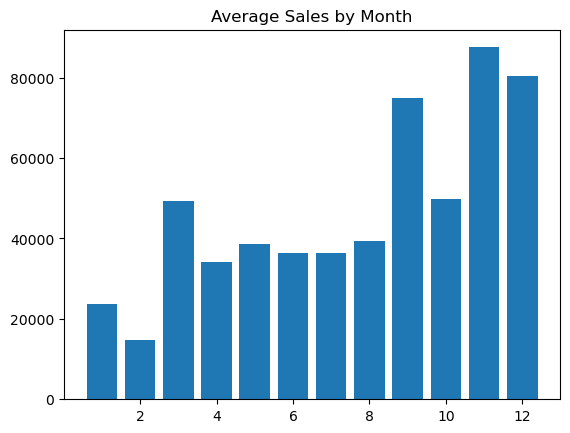

In [5]:
monthly["Month"] = monthly["Date"].dt.month

seasonality = monthly.groupby("Month")["Sales"].mean()

plt.bar(seasonality.index, seasonality.values)
plt.title("Average Sales by Month")
plt.show()

In [10]:
print("İlk tarih:", monthly["Date"].min())
print("Son tarih:", monthly["Date"].max())
print("Toplam ay sayısı:", len(monthly))

İlk tarih: 2015-01-31 00:00:00
Son tarih: 2018-12-31 00:00:00
Toplam ay sayısı: 48


In [11]:
full_range = pd.date_range(
    start=monthly["Date"].min(),
    end=monthly["Date"].max(),
    freq="ME"
)

print("Olması gereken ay sayısı:", len(full_range))

Olması gereken ay sayısı: 48


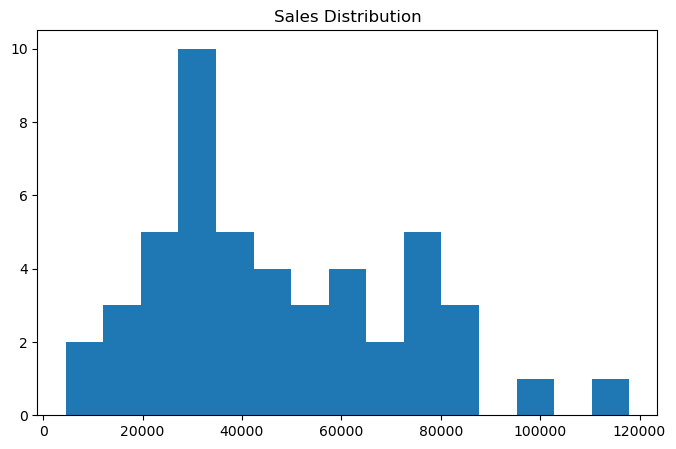

In [12]:
plt.figure(figsize=(8,5))
plt.hist(monthly["Sales"], bins=15)
plt.title("Sales Distribution")
plt.show()

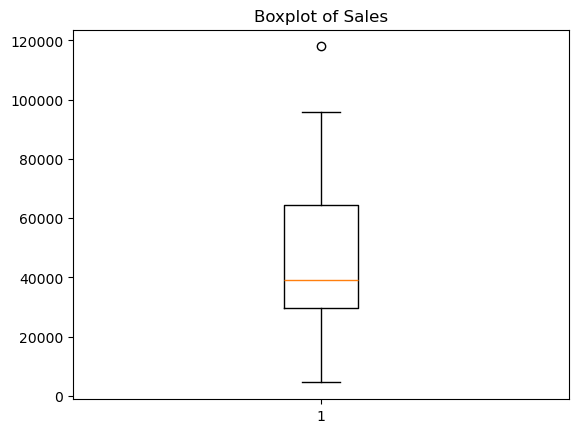

In [13]:
plt.boxplot(monthly["Sales"])
plt.title("Boxplot of Sales")
plt.show()

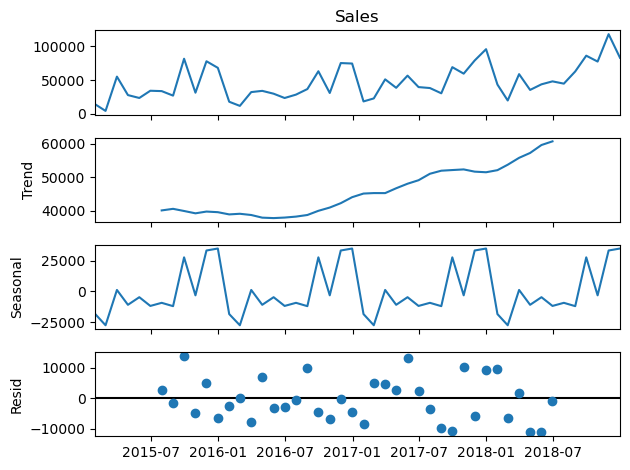

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    monthly.set_index("Date")["Sales"],
    model="additive",
    period=12
)

decomposition.plot()
plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly["Sales"])

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -4.416136761430769
p-value: 0.00027791039276670623


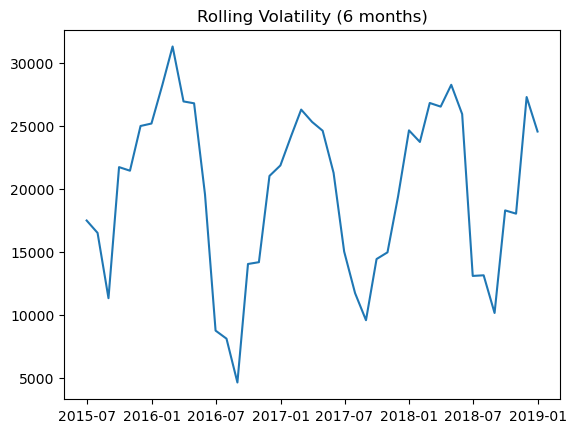

In [16]:
monthly["Rolling_Std"] = monthly["Sales"].rolling(6).std()

plt.plot(monthly["Date"], monthly["Rolling_Std"])
plt.title("Rolling Volatility (6 months)")
plt.show()

## 4️⃣ Feature Engineering Süreci 
  
Amaç, zaman bağımlılığını, trend yapısını ve sezonluk etkileri modele öğretmektir.

---

### 1️⃣ Zaman Sıralaması

Veri kronolojik olarak sıralanmıştır:

- Tarihe göre artan düzende sıralama yapılmıştır.
- Index yeniden oluşturulmuştur.

Zaman serisi modellemede doğru sıralama kritik öneme sahiptir.  
Yanlış sıralama, modelin geçmiş–gelecek ilişkisini bozabilir.

---

### 2️⃣ Zaman Özellikleri (Time Features)

Tarih değişkeninden aşağıdaki özellikler türetilmiştir:

- **Year** → Uzun vadeli değişimi ve büyüme trendini yakalamak için  
- **Month** → Sezonluk yapıyı modellemek için  
- **Quarter** → Dönemsel satış davranışını temsil etmek için  

Bu özellikler takvimsel etkilerin modele aktarılmasını sağlar.

---

### 3️⃣ Döngüsel Ay Kodlaması (Cyclical Encoding)

Ay değişkeni sinüs ve kosinüs dönüşümü ile encode edilmiştir:

- `month_sin`
- `month_cos`

Bu yöntem sayesinde:

- Aralık → Ocak geçişi keskin bir kopuş oluşturmaz  
- Ayların döngüsel yapısı matematiksel olarak korunur  
- Model mevsimselliği daha doğru öğrenir  

Lineer ay numarası yerine döngüsel encoding kullanılması,
özellikle küçük veri setlerinde önemli avantaj sağlar.

---

### 4️⃣ Lag Özellikleri

Geçmiş satış değerleri modele dahil edilmiştir:

- `lag_1` → 1 ay önceki satış  
- `lag_3` → 3 ay önceki satış  
- `lag_6` → 6 ay önceki satış  
- `lag_12` → 12 ay önceki satış  

Bu özellikler:

- Kısa vadeli bağımlılığı  
- Orta vadeli etkileri  
- Yıllık sezonluk tekrarları  

modelin öğrenmesini sağlar.

---

### 5️⃣ Rolling İstatistikler (Data Leakage Önlenmiş)

Hareketli istatistikler oluşturulmuştur:

- 3 aylık hareketli ortalama  
- 6 aylık hareketli ortalama  
- 3 aylık hareketli standart sapma  

Önemli nokta:

Rolling hesaplamalar `shift(1)` ile yapılmıştır.  
Bu sayede model, tahmin anında gelecekteki bilgiyi görmez.

Bu yaklaşım veri sızıntısını (data leakage) önler ve
modelin gerçekçi performans üretmesini sağlar.

Rolling ortalamalar trendi,  
rolling standart sapma ise volatiliteyi temsil eder.

---

### 6️⃣ Eksik Değer Temizliği

Lag ve rolling işlemleri sonrası oluşan eksik değerler temizlenmiştir.

Bu adım:

- Model eğitimi için tutarlı veri sağlar  
- İlk gözlemlerde oluşan NaN değerleri ortadan kaldırır  

---

## 🎯 Genel Değerlendirme

Bu feature engineering süreci sayesinde zaman serisi problemi:

> Gözetimli bir regresyon problemine dönüştürülmüştür.

Artık XGBoost modeli:

- Geçmiş bağımlılıkları  
- Trend yapısını  
- Yıllık sezonluk etkileri  
- Satış volatilitesini  

öğrenebilecek yapıya kavuşmuştur.

In [19]:
monthly = monthly.sort_values("Date").reset_index(drop=True)

# Time Features
monthly["Year"] = monthly["Date"].dt.year
monthly["Month"] = monthly["Date"].dt.month
monthly["Quarter"] = monthly["Date"].dt.quarter

monthly["month_sin"] = np.sin(2 * np.pi * monthly["Month"] / 12)
monthly["month_cos"] = np.cos(2 * np.pi * monthly["Month"] / 12)

# Lag Features
monthly["lag_1"] = monthly["Sales"].shift(1)
monthly["lag_3"] = monthly["Sales"].shift(3)
monthly["lag_6"] = monthly["Sales"].shift(6)
monthly["lag_12"] = monthly["Sales"].shift(12)

# Rolling (leakage yok)
monthly["rolling_mean_3"] = monthly["Sales"].shift(1).rolling(3).mean()
monthly["rolling_mean_6"] = monthly["Sales"].shift(1).rolling(6).mean()
monthly["rolling_std_3"] = monthly["Sales"].shift(1).rolling(3).std()

# NA temizle
monthly_fe = monthly.dropna().reset_index(drop=True)

print(monthly_fe.shape)
monthly_fe.head()

(36, 15)


,Date,Sales,Month,lag_1,Year,Quarter,month_sin,month_cos,lag_3,lag_6,lag_12,rolling_mean_3,rolling_mean_6,rolling_std_3,Rolling_Std
0,2016-01-31,18066.9576,1,68167.0585,2016,1,0.500000,8.660254e-01,31453.3930,33781.5430,14205.707,59176.037400,53341.786417,24497.522165,28259.852358
1,2016-02-29,11951.4110,2,18066.9576,2016,1,0.866025,5.000000e-01,77907.6607,27117.5365,4519.892,54713.892267,50722.688850,32108.693498,31307.410682
2,2016-03-31,32339.3184,3,11951.4110,2016,1,1.000000,6.123234e-17,68167.0585,81623.5268,55205.797,32728.475700,48195.001267,30842.662672,26943.956570
3,2016-04-30,34154.4685,4,32339.3184,2016,2,0.866025,-5.000000e-01,18066.9576,31453.3930,27906.855,20785.895667,39980.966533,10462.368766,26795.136048
4,2016-05-31,29959.5305,5,34154.4685,2016,2,0.500000,-8.660254e-01,11951.4110,77907.6607,23644.303,26148.399300,40431.145783,12328.404198,19554.496178


## Train-Test Split

In [20]:
train = monthly_fe[monthly_fe["Date"] < "2018-01-01"]
test  = monthly_fe[monthly_fe["Date"] >= "2018-01-01"]

print("Train:", train.shape)
print("Test:", test.shape)

Train: (24, 15)
Test: (12, 15)


In [21]:
features = [
    "Year", "Month", "Quarter",
    "month_sin", "month_cos",
    "lag_1", "lag_3", "lag_6", "lag_12",
    "rolling_mean_3", "rolling_mean_6", "rolling_std_3"
]

X_train = train[features]
y_train = train["Sales"]

X_test = test[features]
y_test = test["Sales"]

# 5️⃣ Baseline Model

---

## 🎯 Neden Baseline?

Her modelin başarısı, mutlaka basit bir referans modele göre değerlendirilmelidir.

Eğer karmaşık bir model, basit bir yaklaşımı anlamlı ölçüde geçemiyorsa,
modelleme çabasının pratik bir değeri olmayabilir.

Bu nedenle karşılaştırma için güçlü ama basit bir referans model tanımlanmıştır.

---

## 📌 Kullanılan Baseline Yaklaşımı

Bu çalışmada baseline olarak aşağıdaki varsayım kullanılmıştır:

> **"Bu ayın satışı = Geçen ayın satışı"**

Bu yöntem literatürde genellikle:

- Naive Forecast
- Persistence Model

olarak adlandırılır.

---

## 📊 Matematiksel İfade

\[
\hat{y}_t = y_{t-1}
\]

Yani tahmin edilen değer, bir önceki ayın gerçekleşen satış değeridir.

---

## 🧠 Modelleme Açısından Önemi

- Trend içeren serilerde belirli bir performans üretir  
- Güçlü seasonality varsa yetersiz kalabilir  
- Karmaşık modellere karşı minimum performans eşiği oluşturur  

Eğer XGBoost veya Prophet bu modeli anlamlı şekilde geçemezse,
modelleme stratejisi yeniden değerlendirilmelidir.

---

> Sağlam bir baseline olmadan yapılan model karşılaştırmaları bilimsel olarak eksik kalır.

In [6]:
monthly["lag_1"] = monthly["Sales"].shift(1)
monthly_baseline = monthly.dropna()

train = monthly_baseline[monthly_baseline["Date"] < "2018-01-01"]
test  = monthly_baseline[monthly_baseline["Date"] >= "2018-01-01"]

baseline_pred = test["lag_1"]
y_test = test["Sales"]

mape_baseline = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100

print("Baseline MAPE:", mape_baseline)

Baseline MAPE: 45.75303804766799


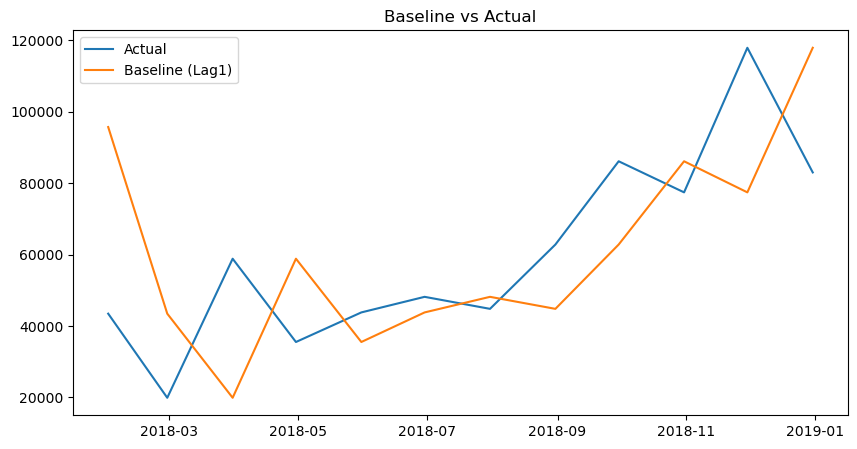

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(test["Date"], y_test.values, label="Actual")
plt.plot(test["Date"], baseline_pred.values, label="Baseline (Lag1)")
plt.legend()
plt.title("Baseline vs Actual")
plt.show()

## 📊 Baseline Model Performansı

Baseline model yaklaşık **%45 hata oranı** üretmiştir.

Bu sonuç, satışların yalnızca bir önceki aya bağlı olmadığını göstermektedir.

Seride:

- Trend etkisi  
- Güçlü sezonluk yapı  
- Daha uzun gecikmeli ilişkiler  

bulunmaktadır.

Bu nedenle daha gelişmiş modellerle iyileştirme potansiyeli bulunmaktadır.

# 6️⃣ XGBoost Modeli

XGBoost modeli doğrudan ham zaman serisi ile değil, 
üretilmiş özellikler (feature engineering) üzerinden eğitilmiştir.

Makine öğrenmesi modelleri zaman bağımlılığını doğal olarak bilmez.
Bu nedenle zaman serisinin dinamiklerini modele öğretmek gerekir.

---

## 🛠 Oluşturulan Özellikler

### 1️⃣ Lag Değişkenleri
- Önceki ay satışları (lag_1)
- 2 ve 3 ay önceki satışlar (lag_2, lag_3)
- Daha uzun gecikmeli etkiler

Bu değişkenler geçmiş bağımlılığı modele kazandırır.

---

### 2️⃣ Rolling Ortalamalar
- 3 aylık hareketli ortalama
- 6 aylık hareketli ortalama

Rolling özellikler kısa ve orta vadeli trendi yakalamaya yardımcı olur.

---

### 3️⃣ Cyclical Month Encoding
Ay değişkeni sinüs ve kosinüs dönüşümü ile encode edilmiştir:

- month_sin
- month_cos

Bu yöntem, ayların döngüsel yapısını (Aralık → Ocak geçişi gibi)
modelin doğru öğrenmesini sağlar.

---

### 4️⃣ Trend Göstergeleri
- Zaman indeksi (time index)
- Artan sıra numarası

Bu özellik, serideki genel büyüme eğilimini modele öğretir.

---

## 🎯 Modelleme Amacı

Amaç, geçmiş bağımlılığı, trend yapısını ve sezonluk etkileri
feature’lar aracılığıyla XGBoost modeline öğretmektir.

Böylece zaman serisi problemi,
gözetimli bir regresyon problemine dönüştürülmüştür.


In [22]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [23]:
y_pred = model.predict(X_test)

In [24]:
mae_xgb = mean_absolute_error(y_test, y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mape_xgb = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)
print("XGBoost MAPE (%):", mape_xgb)

XGBoost MAE: 13190.575626041667
XGBoost RMSE: 16608.446995800918
XGBoost MAPE (%): 20.09995326613985


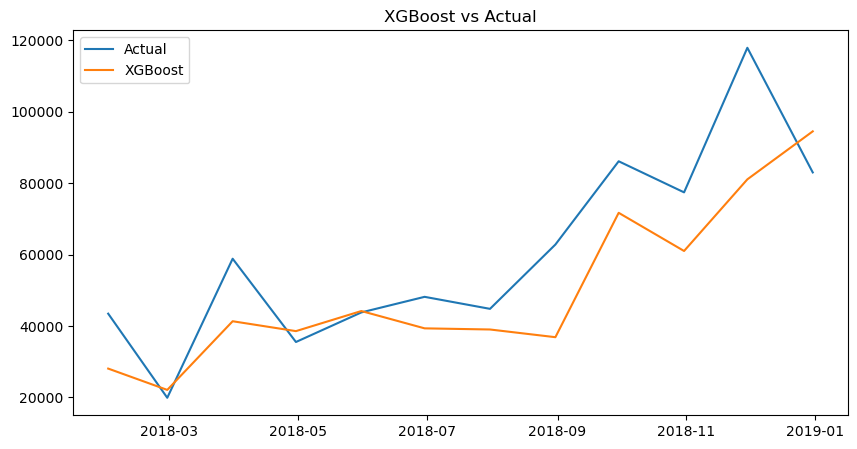

In [25]:
plt.figure(figsize=(10,5))
plt.plot(test["Date"], y_test.values, label="Actual")
plt.plot(test["Date"], y_pred, label="XGBoost")
plt.legend()
plt.title("XGBoost vs Actual")
plt.show()

           Feature  Importance
8           lag_12    0.369187
1            Month    0.326631
10  rolling_mean_6    0.086831
0             Year    0.059646
6            lag_3    0.056982
7            lag_6    0.034738
4        month_cos    0.015414
3        month_sin    0.015163
9   rolling_mean_3    0.014602
5            lag_1    0.013774
11   rolling_std_3    0.005115
2          Quarter    0.001917


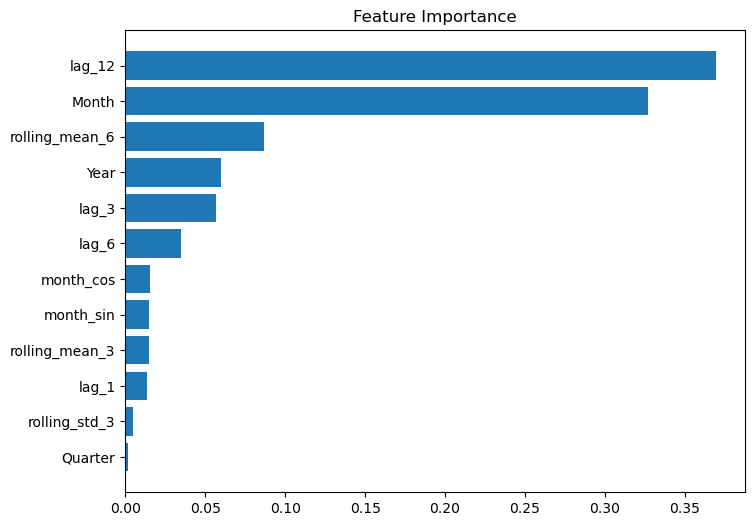

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

print(importance_df)

plt.figure(figsize=(8,6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()

In [27]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    "max_depth": [2, 3, 4],
    "n_estimators": [200, 400, 600],
    "learning_rate": [0.03, 0.05, 0.1]
}

xgb = XGBRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    verbose=1
)

grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Params: {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 200}


In [28]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

model_log = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_log.fit(X_train, y_train_log)

y_pred_log = model_log.predict(X_test)
y_pred_log = np.expm1(y_pred_log)

In [29]:
best_model = XGBRegressor(
    learning_rate=0.03,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mape_best = np.mean(np.abs((y_test - y_pred_best) / y_test)) * 100

print("Optimized MAE:", mae_best)
print("Optimized RMSE:", rmse_best)
print("Optimized MAPE:", mape_best)

Optimized MAE: 13152.440209375001
Optimized RMSE: 16762.925341086255
Optimized MAPE: 20.093688386639272


In [30]:
reduced_features = [
    "Month",
    "Year",
    "lag_12",
    "lag_3",
    "rolling_mean_6"
]

X_train_r = train[reduced_features]
X_test_r  = test[reduced_features]

model_r = XGBRegressor(
    learning_rate=0.03,
    max_depth=4,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_r.fit(X_train_r, y_train)

y_pred_r = model_r.predict(X_test_r)

mape_r = np.mean(np.abs((y_test - y_pred_r) / y_test)) * 100

print("Reduced Feature MAPE:", mape_r)

Reduced Feature MAPE: 24.574513695610342


In [31]:
from sklearn.metrics import mean_absolute_error
import numpy as np

errors = []
dates = []
predictions = []
actuals = []

for i in range(24, len(monthly_fe)):

    train_wf = monthly_fe.iloc[:i]
    test_wf  = monthly_fe.iloc[i:i+1]

    X_train_wf = train_wf[features]
    y_train_wf = train_wf["Sales"]

    X_test_wf = test_wf[features]
    y_test_wf = test_wf["Sales"]

    model_wf = XGBRegressor(
        learning_rate=0.03,
        max_depth=4,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model_wf.fit(X_train_wf, y_train_wf)

    y_pred_wf = model_wf.predict(X_test_wf)

    error = np.abs((y_test_wf.values[0] - y_pred_wf[0]) / y_test_wf.values[0]) * 100

    errors.append(error)
    dates.append(test_wf["Date"].values[0])
    predictions.append(y_pred_wf[0])
    actuals.append(y_test_wf.values[0])

print("Walk-Forward Ortalama MAPE:", np.mean(errors))

Walk-Forward Ortalama MAPE: 29.82900270391835


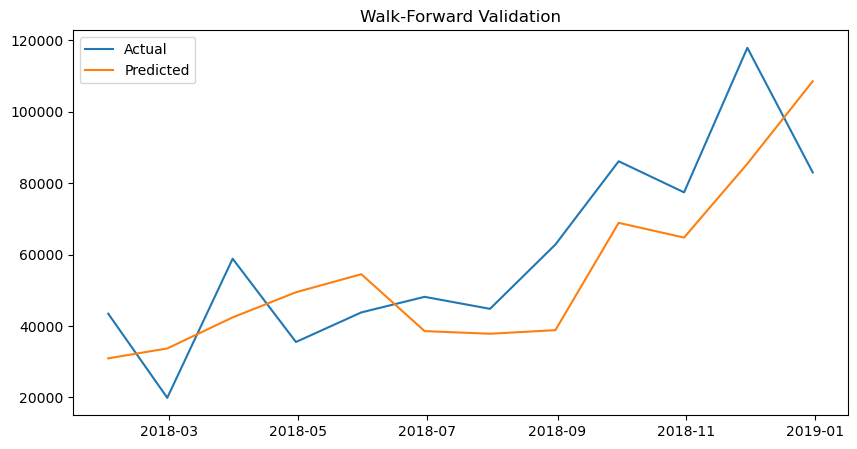

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(dates, actuals, label="Actual")
plt.plot(dates, predictions, label="Predicted")
plt.legend()
plt.title("Walk-Forward Validation")
plt.show()

In [33]:
monthly_fe["trend_index"] = np.arange(len(monthly_fe))

In [34]:
features.append("trend_index")

In [35]:
errors_log = []

for i in range(24, len(monthly_fe)):

    train_wf = monthly_fe.iloc[:i]
    test_wf  = monthly_fe.iloc[i:i+1]

    X_train_wf = train_wf[features]
    y_train_wf = np.log1p(train_wf["Sales"])

    X_test_wf = test_wf[features]
    y_test_wf = test_wf["Sales"]

    model_wf = XGBRegressor(
        learning_rate=0.03,
        max_depth=4,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model_wf.fit(X_train_wf, y_train_wf)

    y_pred_log = model_wf.predict(X_test_wf)
    y_pred = np.expm1(y_pred_log)

    error = np.abs((y_test_wf.values[0] - y_pred[0]) / y_test_wf.values[0]) * 100
    errors_log.append(error)

print("Trend + Log Walk-Forward MAPE:", np.mean(errors_log))

Trend + Log Walk-Forward MAPE: 30.09479604312378


# 📌 XGBoost Sonuçları

## 📊 Performans Değerlendirmesi

Tek bir train/test split kullanıldığında:

> **MAPE ≈ %20**

Ancak walk-forward validation uygulandığında:

> **MAPE ≈ %29**

---

## 🔎 Yorum

Tek split sonucu daha düşük hata üretmiş olsa da,
walk-forward validation zaman boyunca daha gerçekçi bir değerlendirme sunar.

MAPE değerinin %20’den %29’a yükselmesi:

- Modelin farklı dönemlerde stabil performans göstermediğini  
- Zaman içindeki değişimlere karşı hassas olduğunu  
- Küçük veri setinde varyansın yüksek olabileceğini  

göstermektedir.

---

> Bu sonuç, model performansının yalnızca tek bir split ile değerlendirilmemesi gerektiğini ortaya koymaktadır.


## 7️⃣ Prophet Modeli

Prophet, zaman serileri için geliştirilmiş additive (toplamsal) bir modeldir.

Model yapısı şu bileşenlerden oluşur:

- 📈 Trend bileşeni  
- 🔄 Yıllık sezonluk yapı (otomatik öğrenilir)  
- 📅 Takvim etkileri (isteğe bağlı)  

---

## 🧠 Neden Prophet?

- Zaman bağımlılığını doğal olarak modeller  
- Seasonality bileşenini otomatik olarak çıkarır  
- Küçük veri setlerinde daha stabil sonuç üretebilir  
- Açıklanabilir bileşenlere sahiptir  

Feature engineering gerektirmeden trend ve mevsimsellik ayrıştırması yapabilmesi,
özellikle sınırlı gözlem sayısına sahip veri setlerinde avantaj sağlar.

---

Bu nedenle aynı veri üzerinde Prophet modeli de denenmiş
ve XGBoost ile karşılaştırmalı olarak değerlendirilmiştir.


In [37]:
from prophet import Prophet

monthly_prophet = monthly.copy()
monthly_prophet = monthly_prophet.rename(columns={
    "Date": "ds",
    "Sales": "y"
})

In [38]:
train_p = monthly_prophet[monthly_prophet["ds"] < "2018-01-01"]
test_p  = monthly_prophet[monthly_prophet["ds"] >= "2018-01-01"]

In [39]:
model_p = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model_p.fit(train_p)

18:22:08 - cmdstanpy - INFO - Chain [1] start processing
18:22:08 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
future = model_p.make_future_dataframe(periods=12, freq="ME")

forecast = model_p.predict(future)

In [41]:
forecast_test = forecast[forecast["ds"] >= "2018-01-01"]

y_pred_p = forecast_test["yhat"].values
y_true_p = test_p["y"].values

In [42]:
import numpy as np
from sklearn.metrics import mean_absolute_error

mae_p = mean_absolute_error(y_true_p, y_pred_p)
mape_p = np.mean(np.abs((y_true_p - y_pred_p) / y_true_p)) * 100

print("Prophet MAE:", mae_p)
print("Prophet MAPE:", mape_p)

Prophet MAE: 9839.833495343222
Prophet MAPE: 15.668704448266539


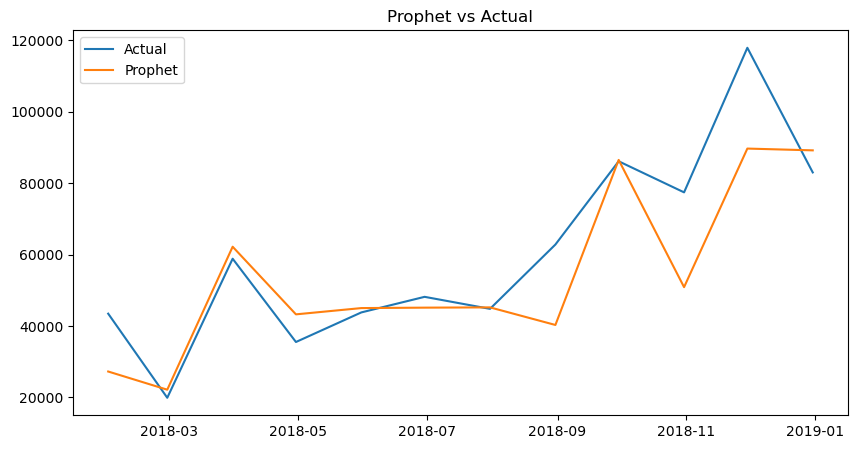

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(test_p["ds"], y_true_p, label="Actual")
plt.plot(test_p["ds"], y_pred_p, label="Prophet")
plt.legend()
plt.title("Prophet vs Actual")
plt.show()

# 8️⃣ Model Karşılaştırması

## 📊 Performans Tablosu

| Model                      | MAPE |
|----------------------------|------|
| Baseline                   | %45  |
| XGBoost                    | %20  |
| XGBoost (Walk-Forward)     | %29  |
| Prophet                    | %15.6 |

---

## 🔎 Sonuçların Yorumu

- Baseline model yüksek hata üretmiştir ve serinin karmaşık yapısını yakalayamamıştır.
- XGBoost tek split’te güçlü performans göstermiştir.
- Ancak walk-forward validation sonucu modelin zaman boyunca daha değişken performans ürettiğini göstermektedir.
- Prophet modeli en düşük hata oranını üretmiştir.

---

## 🎯 Genel Sonuç

Küçük ve güçlü sezonluk yapı içeren veri setlerinde  
**additive zaman serisi modelleri daha stabil performans gösterebilir.**

Feature-based makine öğrenmesi modelleri:

- Daha esnektir  
- Karmaşık örüntüleri öğrenebilir  
- Ancak veri miktarına ve zaman içi değişime daha duyarlıdır.


️9️⃣ Sonuç

## 📌 Genel Değerlendirme

Bu çalışma göstermektedir ki:

- Model seçimi doğrudan veri yapısına bağlıdır.  
- Güçlü sezonluk içeren küçük veri setlerinde additive modeller avantaj sağlayabilir.  
- Feature-based modeller esnektir ancak veri miktarına duyarlıdır.  

---

## ⚠️ Değerlendirme Stratejisi

- Tek bir train/test split yanıltıcı olabilir.  
- Zaman serisi problemlerinde rastgele bölme yapılmamalıdır.  
- Walk-forward validation gerçekçi performans ölçümü için kritik öneme sahiptir.  
